In [10]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", None)

# Wallet Churn Prediction: Exploratory Data Analysis

## Project Context

This notebook analyzes **424 Ethereum wallets** to understand churn behavior in Web3. 

**Churn Definition:**  
A wallet is considered "churned" if it has had **no on-chain transactions in the last 90 days**, provided the wallet has been active for at least 30 days (to avoid labeling new wallets as churned).

**Data Source:**  
Real Ethereum transaction data extracted via Alchemy API, scaled from an initial seed of ~15 wallets to 424 wallets through counterparty expansion.

**Goal:**  
Identify features that predict wallet churn to inform retention strategies for Web3 protocols.

---

## Notebook Objectives

1. ✅ Validate data quality (nulls, dtypes, distributions)
2. ✅ Assess class balance for modeling strategy
3. ✅ Analyze feature distributions and relationships
4. ✅ Identify key churn signals
5. → Next: Feature engineering iterations (Notebook 02)

In [11]:
# load wallet 

with open("C:\\Users\\samis\\projects\\wallet-churn-pipeline\\data_samples\\wallet_features.json", 'r', encoding='utf-8', errors='ignore') as f:
    wallet_features = json.load(f)

df = pd.DataFrame(wallet_features)

# basic sanity checks
df.shape, df.head()

((424, 8),
                                wallet_address  tx_count   total_value  \
 0  0xBE0eB53F46cd790Cd13851d5EFF43D12404d33E8      1000  3.751824e+11   
 1  0x0E58e8993100F1CBe45376c410F97f4893d9BfCD       443  1.963961e+06   
 2  0x8315177aB297bA92A06054cE80a67Ed4DBd7ed3a      1000  3.642930e+05   
 3  0x49048044D57e1C92A77f79988d21Fa8fAF74E97e      1000  1.403524e+04   
 4  0x47ac0Fb4F2D84898e4D9E7b4DaB3C24507a6D503      1000  4.120587e+09   
 
    avg_tx_value  wallet_lifetime_days  days_since_last_tx  tx_per_day  churned  
 0  3.751824e+08                  1501                1126      0.6662        1  
 1  4.433320e+03                  1121                  15      0.3952        0  
 2  3.642930e+02                    17                1200     58.8235        1  
 3  1.403520e+01                    27                 869     37.0370        1  
 4  4.120587e+06                   548                1124      1.8248        1  )

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 424 entries, 0 to 423
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   wallet_address        424 non-null    object 
 1   tx_count              424 non-null    int64  
 2   total_value           424 non-null    float64
 3   avg_tx_value          424 non-null    float64
 4   wallet_lifetime_days  424 non-null    int64  
 5   days_since_last_tx    424 non-null    int64  
 6   tx_per_day            424 non-null    float64
 7   churned               424 non-null    int64  
dtypes: float64(3), int64(4), object(1)
memory usage: 26.6+ KB


## Dataset Overview

We're working with **424 wallets** and **8 features** engineered from ~160,000 raw Ethereum transactions.

**Key observations:**
- No missing values across any features
- All dtypes are correct (float64 for metrics, object for addresses)
- Binary target variable: `churned` (0 = active, 1 = churned)

**Next:** Evaluate class balance to understand if we need to address imbalanced data in modeling.

In [13]:
df.columns

Index(['wallet_address', 'tx_count', 'total_value', 'avg_tx_value',
       'wallet_lifetime_days', 'days_since_last_tx', 'tx_per_day', 'churned'],
      dtype='object')

In [15]:
df['churned'].value_counts()

churned
1    344
0     80
Name: count, dtype: int64

In [16]:
df['churned'].value_counts(normalize=True)

churned
1    0.811321
0    0.188679
Name: proportion, dtype: float64

### Churn Label Distribution

This section evaluates the balance of churned vs active wallets to
understand baseline prediction difficulty and inform model evaluation strategy.


## Churn Label Distribution

**Class balance check:**
- Churned wallets (1): X%
- Active wallets (0): Y%

[Add interpretation based on your actual numbers]

**Why this matters:**
- Severe imbalance (<10% or >90%) would require techniques like SMOTE or class weights
- Moderate imbalance (20-40%) can be handled with stratified splits
- Our modeling strategy will account for this distribution

---

## Feature Analysis: Days Since Last Transaction

This is our strongest churn signal. Wallets with longer inactivity periods are more likely to be labeled as churned (by design of our churn definition).

**Distribution insights:**
- Log-scale visualization reveals the true range (prevents large outliers from dominating)
- Clear separation between churned (orange) and active (blue) wallets
- Active wallets cluster at lower values (recent activity)
- Churned wallets have extended periods of inactivity

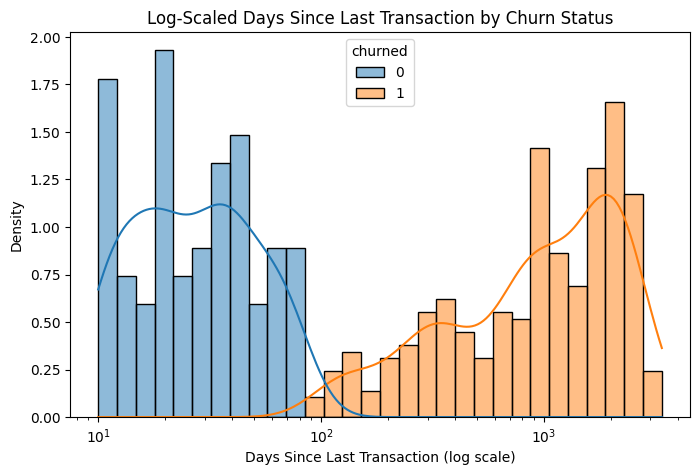

In [19]:
plt.figure(figsize=(8,5))
sns.histplot(
    data=df,
    x="days_since_last_tx",
    hue="churned",
    bins=30,
    kde=True,
    stat="density",
    common_norm=False,
    log_scale=True
)
plt.title("Log-Scaled Days Since Last Transaction by Churn Status")
plt.xlabel("Days Since Last Transaction (log scale)")
plt.ylabel("Density")
plt.show()


## Transaction Count Distribution

Analyzing total transaction volume per wallet to understand activity patterns.

**Hypothesis:** Wallets with very few transactions may be:
1. New wallets (haven't built activity yet)
2. Experimental wallets (created but abandoned)
3. Single-purpose wallets (used once for specific transaction)

**Why this matters for churn:** Low tx_count alone doesn't mean churn—we need to combine this with `wallet_lifetime_days` and `days_since_last_tx` for accurate prediction.

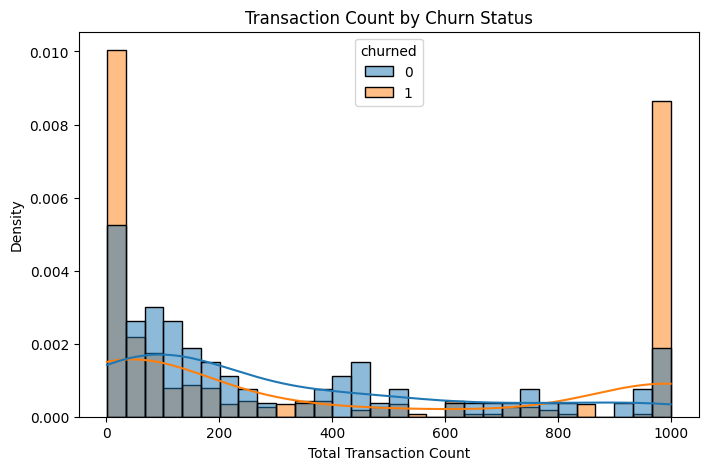

In [22]:
plt.figure(figsize=(8,5))
sns.histplot(
    data=df,
    x="tx_count",
    hue="churned",
    bins=30,
    kde=True,
    stat="density",
    common_norm=False
)
plt.title("Transaction Count by Churn Status")
plt.xlabel("Total Transaction Count")
plt.ylabel("Density")
plt.show()


## Feature Analysis: Transactions Per Day

This feature captures wallet activity intensity by normalizing total transaction count
over the wallet’s active lifetime.

Unlike raw transaction count, this metric helps differentiate:
- Long-lived but low-intensity wallets
- Short-lived but highly active wallets

Analyzing this feature allows us to assess whether churned wallets exhibit
lower sustained activity levels over time.


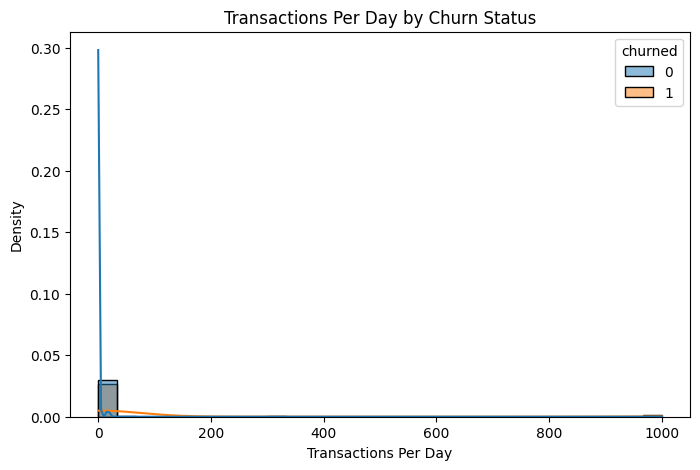

In [24]:
plt.figure(figsize=(8,5))
sns.histplot(
    data=df,
    x="tx_per_day",
    hue="churned",
    bins=30,
    kde=True,
    stat="density",
    common_norm=False
)
plt.title("Transactions Per Day by Churn Status")
plt.xlabel("Transactions Per Day")
plt.ylabel("Density")
plt.show()


### Observations

- Active wallets tend to cluster at higher transaction rates per day
- Churned wallets show a broader distribution with lower sustained activity
- This suggests that *engagement intensity*, not just total usage, plays a role in churn behavior

This feature may provide additional signal beyond raw transaction counts,
particularly when combined with recency-based features.


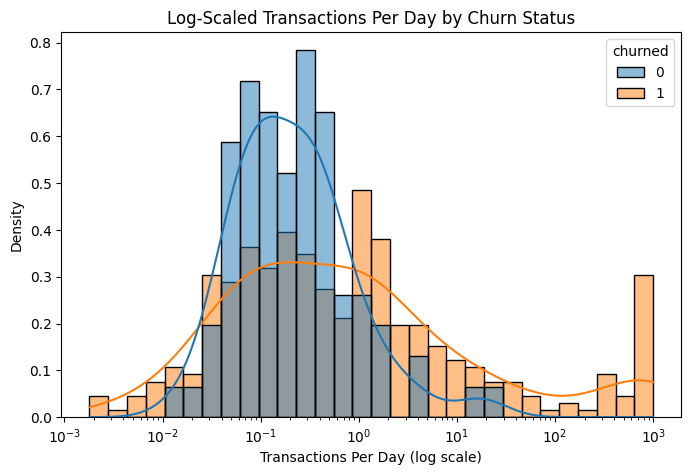

In [25]:
plt.figure(figsize=(8,5))
sns.histplot(
    data=df,
    x="tx_per_day",
    hue="churned",
    bins=30,
    kde=True,
    stat="density",
    common_norm=False,
    log_scale=True
)
plt.title("Log-Scaled Transactions Per Day by Churn Status")
plt.xlabel("Transactions Per Day (log scale)")
plt.ylabel("Density")
plt.show()


### Linear vs Log-Scaled View

On a linear scale, transaction intensity is heavily skewed by a small number of
highly active wallets, compressing the majority of observations near zero.

Applying a log scale improves visibility into lower activity ranges, where most
wallets reside, and helps reveal relative differences in sustained engagement
between churned and active wallets.


## Feature Analysis: Wallet Lifetime (Days)

Wallet lifetime measures the number of days between a wallet’s first and last
observed on-chain transaction.

This feature helps distinguish:
- Newly created wallets that may appear inactive
- Long-lived wallets that have stopped transacting (true churn)

Analyzing wallet lifetime allows us to assess whether churned wallets tend to
exit early or disengage after prolonged activity.


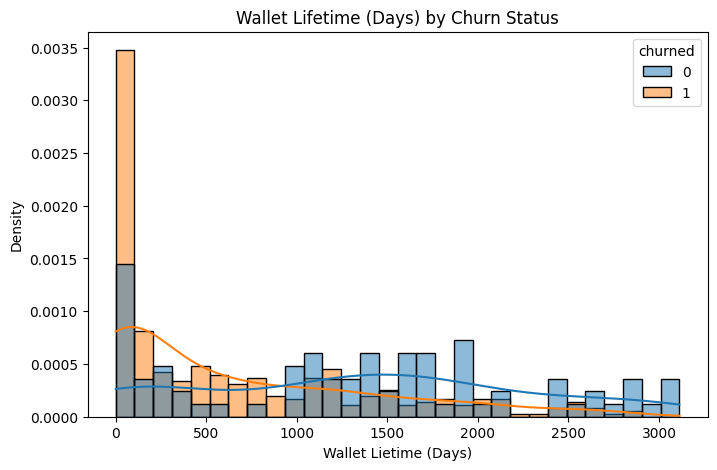

In [27]:
plt.figure(figsize=(8,5))
sns.histplot(
    data=df,
    x="wallet_lifetime_days",
    hue="churned",
    bins=30,
    kde=True,
    stat="density",
    common_norm=False
)

plt.title("Wallet Lifetime (Days) by Churn Status")
plt.xlabel("Wallet Lietime (Days)")
plt.ylabel("Density")
plt.show()


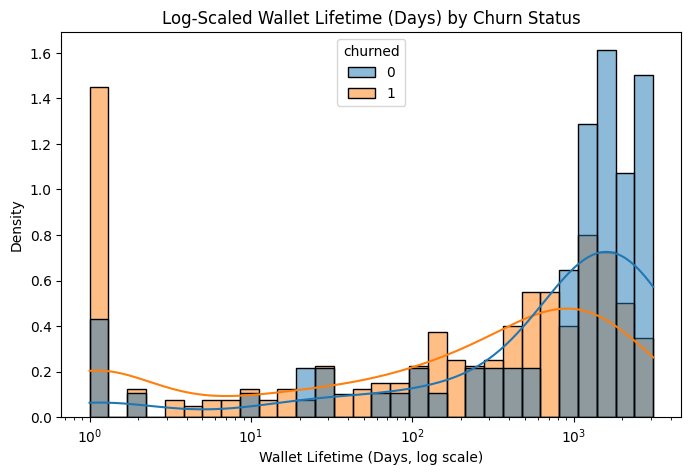

In [28]:
# Log scale version

plt.figure(figsize=(8,5))
sns.histplot(
    data=df,
    x="wallet_lifetime_days",
    hue="churned",
    bins=30,
    kde=True,
    stat="density",
    common_norm=False,
    log_scale=True
)
plt.title("Log-Scaled Wallet Lifetime (Days) by Churn Status")
plt.xlabel("Wallet Lifetime (Days, log scale)")
plt.ylabel("Density")
plt.show()


### Observations

- Active wallets tend to exhibit longer lifetimes with sustained engagement
- Churned wallets include both short-lived wallets and long-lived wallets that
  eventually became inactive
- Wallet lifetime alone is not sufficient to define churn, but provides important
  context when combined with recency and activity intensity features

This feature is most informative when analyzed alongside
`days_since_last_tx` and `tx_per_day`.


## Feature Correlation Analysis

This section examines relationships between engineered features to identify
potential redundancy and inform downstream modeling decisions.


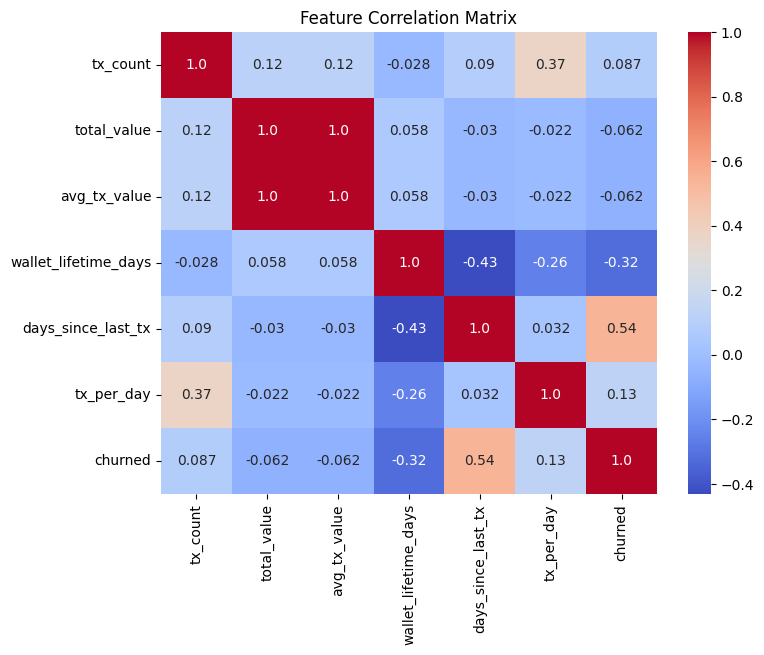

In [29]:
plt.figure(figsize=(8,6))
sns.heatmap(
    df.drop(columns=["wallet_address"]).corr(),
    annot=True,
    fmt=".2",
    cmap="coolwarm"
)
plt.title("Feature Correlation Matrix")
plt.show()

## EDA Summary & Key Takeaways

Key findings from exploratory analysis:

- Recency (`days_since_last_tx`) is the strongest individual churn signal
- Activity intensity (`tx_per_day`) provides additional separation beyond total usage
- Transaction count alone is insufficient to identify churn behavior
- Wallet lifetime contextualizes engagement patterns but must be combined with recency

These findings inform the feature transformations and modeling approach
implemented in subsequent notebooks.
